In [28]:
!pip install seaborn

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
player_stats = pd.read_csv('PLAYER STATS.csv')
season_stats = pd.read_csv('SEASON-STATS.csv')
match_results = pd.read_csv('MATCH-RESULTS.csv')

last_two_seasons = sorted(match_results['Season_End_Year'].unique())[-2:] # Filter data to only include the last two seasons
player_stats = player_stats[player_stats['Season'].isin(last_two_seasons)] # Same
season_stats = season_stats[season_stats['Season_End_Year'].isin(last_two_seasons)] # Same
match_results = match_results[match_results['Season_End_Year'].isin(last_two_seasons)] #Same

sns.set_style('whitegrid')


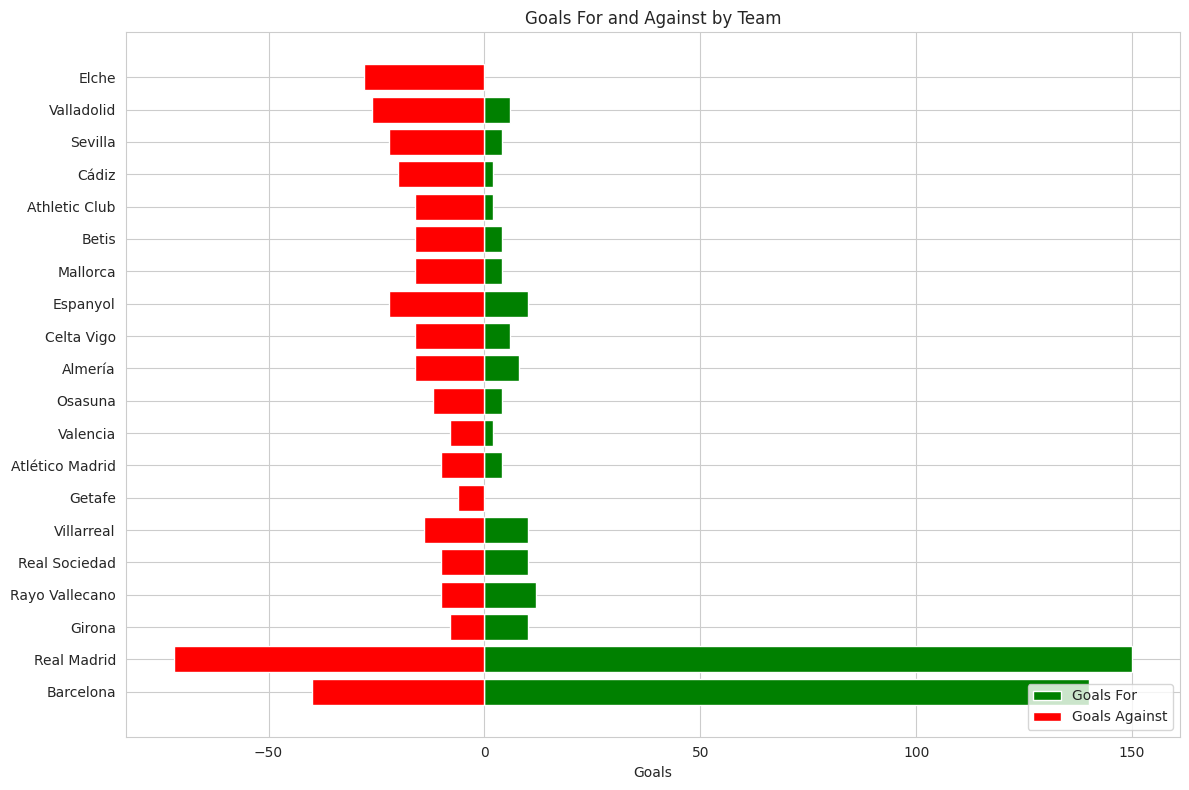

In [44]:
# Goals For and Against by Team
def plot_goals_for_against(match_results):
    # Calculate goals for and against for each team
    home_stats = match_results.groupby('Home').agg({'HomeGoals': 'sum', 'AwayGoals': 'sum'}).reset_index()
    away_stats = match_results.groupby('Away').agg({'AwayGoals': 'sum', 'HomeGoals': 'sum'}).reset_index()

    home_stats = home_stats.rename(columns={'Home': 'Squad', 'HomeGoals': 'Goals_For_Home', 'AwayGoals': 'Goals_Against_Home'})
    away_stats = away_stats.rename(columns={'Away': 'Squad', 'AwayGoals': 'Goals_For_Away', 'HomeGoals': 'Goals_Against_Away'})

    # Merge home and away stats
    total_goals = pd.merge(home_stats, away_stats, on='Squad', how='outer').fillna(0)

    # Calculate total goals for and against
    total_goals['Goals_For'] = total_goals['Goals_For_Home'] + total_goals['Goals_For_Away']
    total_goals['Goals_Against'] = total_goals['Goals_Against_Home'] + total_goals['Goals_Against_Away']
    total_goals['Goal_Difference'] = total_goals['Goals_For'] - total_goals['Goals_Against']

    # Sort teams by goal difference
    total_goals = total_goals.sort_values('Goal_Difference', ascending=False)

    # Plotting goals for and against
    plt.figure(figsize=(12, 8))
    plt.barh(total_goals['Squad'], total_goals['Goals_For'], color='green', label='Goals For')
    plt.barh(total_goals['Squad'], -total_goals['Goals_Against'], color='red', label='Goals Against')
    plt.title('Goals For and Against by Team')
    plt.xlabel('Goals')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

plot_goals_for_against(match_results)

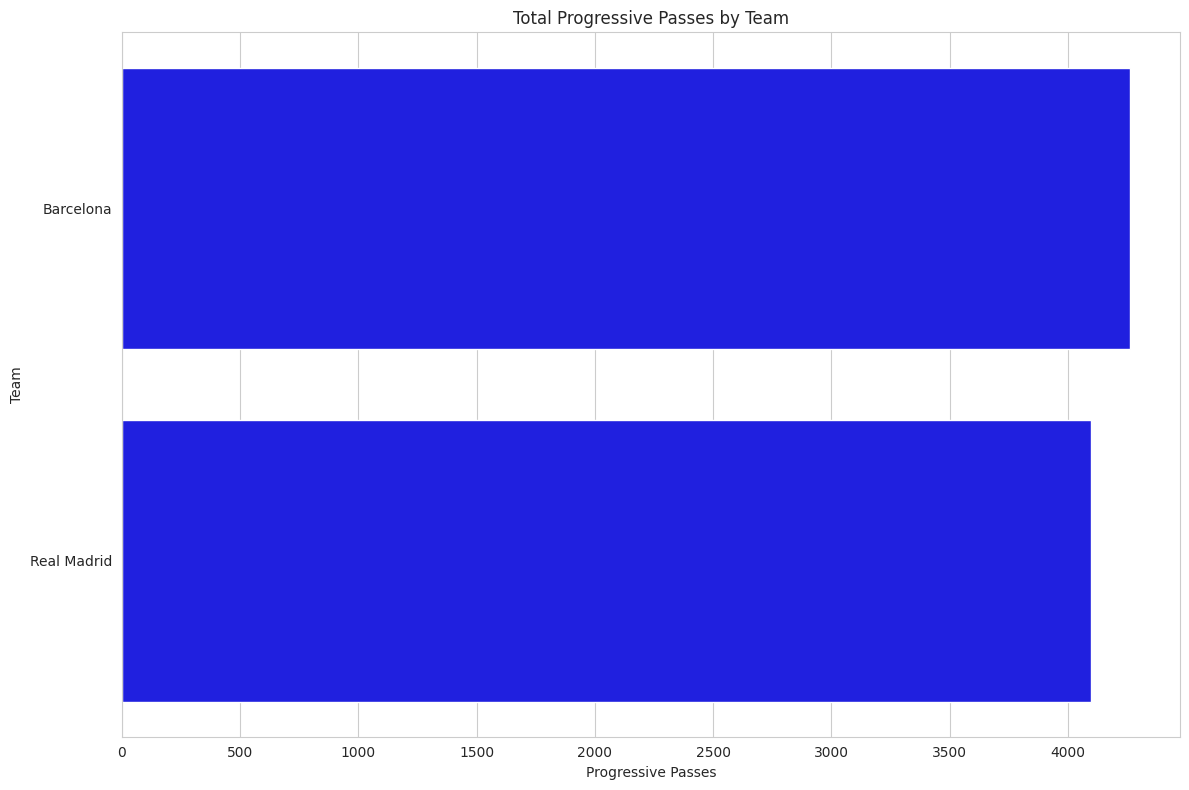

In [45]:
# Progressive Passes by Team
def plot_passing_progression(season_stats):
    if 'PrgP_Progression' not in season_stats.columns:
        print("Column 'PrgP_Progression' not found in season_stats.")
        return

    # Aggregate progressive passes for each team
    passing_stats = season_stats.groupby('Squad')['PrgP_Progression'].sum().reset_index()
    passing_stats = passing_stats.sort_values('PrgP_Progression', ascending=False)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(data=passing_stats, x='PrgP_Progression', y='Squad', color='blue')
    plt.title('Total Progressive Passes by Team')
    plt.xlabel('Progressive Passes')
    plt.ylabel('Team')
    plt.tight_layout()
    plt.show()

plot_passing_progression(season_stats)

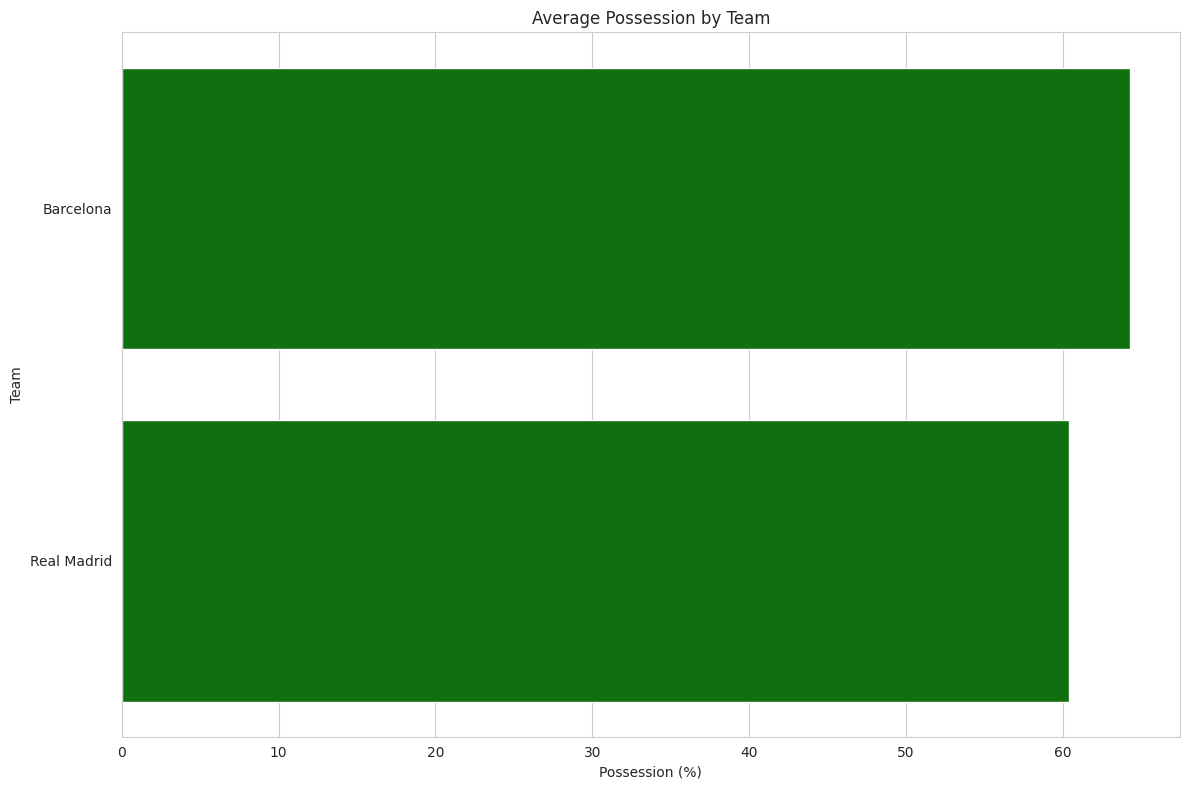

In [46]:
# Average Possession by Team
def plot_possession_stats(season_stats):
    if 'Poss' not in season_stats.columns: # checks if Poss column exists
        print("Column 'Poss' not found in season_stats.")
        return

    possession = season_stats.groupby('Squad')['Poss'].mean().reset_index()
    possession = possession.sort_values('Poss', ascending=False)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(data=possession, x='Poss', y='Squad', color='green')
    plt.title('Average Possession by Team')
    plt.xlabel('Possession (%)')
    plt.ylabel('Team')
    plt.tight_layout()
    plt.show()

plot_possession_stats(season_stats)

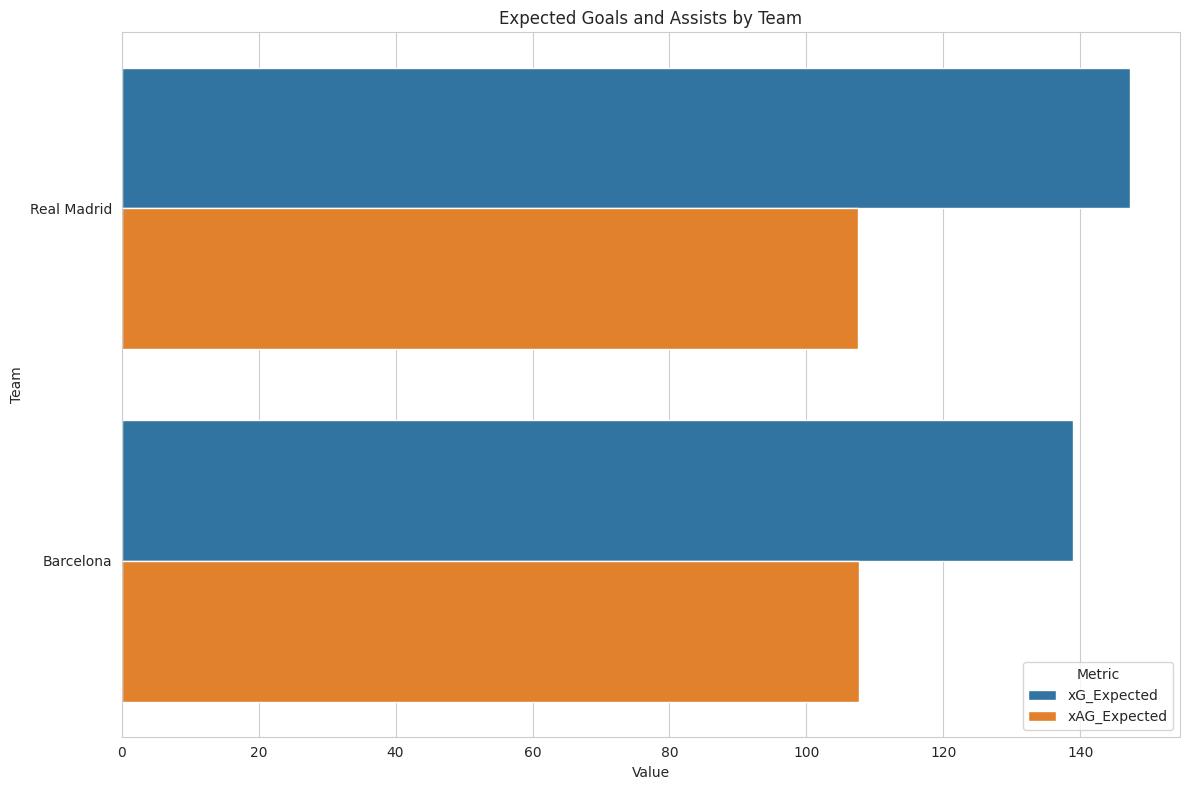

In [47]:
# Expected Goals and Assists by Team
def plot_shooting_stats(season_stats):
    required_columns = ['Squad', 'xG_Expected', 'xAG_Expected']
    for col in required_columns:
        if col not in season_stats.columns:
            print(f"Column '{col}' not found in season_stats.")
            return

    shooting_stats = season_stats.groupby('Squad')[['xG_Expected', 'xAG_Expected']].sum().reset_index()
    shooting_stats = shooting_stats.sort_values('xG_Expected', ascending=False)

    # Melt the dataframe for plotting
    shooting_stats_melted = shooting_stats.melt(id_vars='Squad', value_vars=['xG_Expected', 'xAG_Expected'], var_name='Metric', value_name='Value')

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(data=shooting_stats_melted, x='Value', y='Squad', hue='Metric')
    plt.title('Expected Goals and Assists by Team')
    plt.xlabel('Value')
    plt.ylabel('Team')
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

plot_shooting_stats(season_stats)

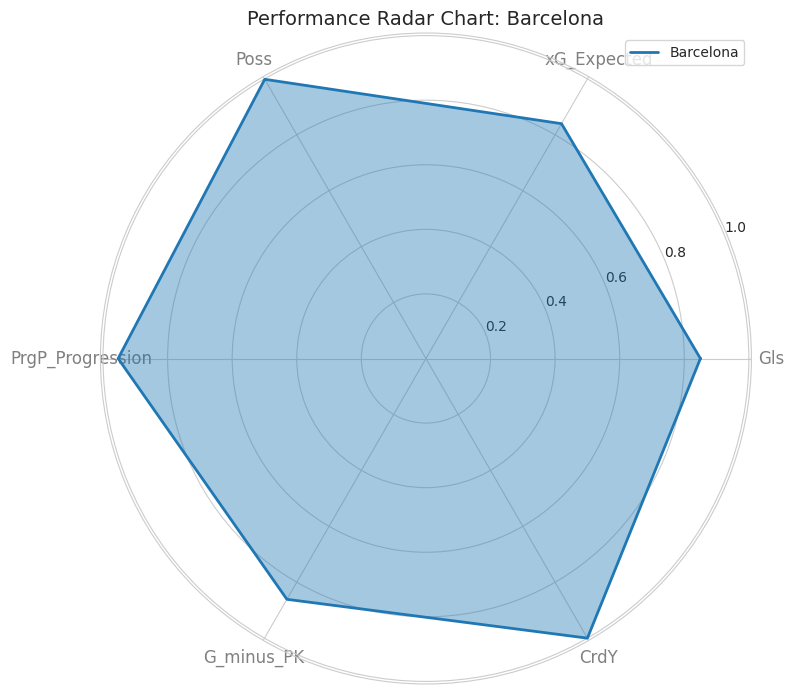

In [49]:
# Team Performance Radar Chart
def plot_team_performance_radar(team_name, season_stats):
    # Select team data
    team_data = season_stats[season_stats['Squad'] == team_name]
    if team_data.empty:
        print(f"No data found for team {team_name}")
        return
    team_data = team_data.iloc[0]
    categories = ['Gls', 'xG_Expected', 'Poss', 'PrgP_Progression', 'G_minus_PK', 'CrdY']

    # Check if all required categories exist
    for cat in categories:
        if cat not in season_stats.columns:
            print(f"Column '{cat}' not found in season_stats.")
            return

    values = [team_data[cat] for cat in categories]

    # Normalize the values between 0 and 1
    max_values = season_stats[categories].max()
    values = [v / max_values[cat] if max_values[cat] != 0 else 0 for v, cat in zip(values, categories)]

    # Number of variables we're plotting
    N = len(categories)

    # Repeat the first value to close the circular graph
    values += values[:1]

    # Calculate angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    # Plotting
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=team_name)
    ax.fill(angles, values, alpha=0.4)
    plt.title(f'Performance Radar Chart: {team_name}', size=14)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage (replace 'Team Name' with an actual team from your dataset):
plot_team_performance_radar('Barcelona', season_stats)

--------------------------------------------------------------------------------
The plot shows how well teams performed in terms of scoring relative to their expected goals:
- Teams above the diagonal line have exceeded their expected goals (scored more than expected).
- Teams below the diagonal line have underperformed (scored fewer goals than expected).

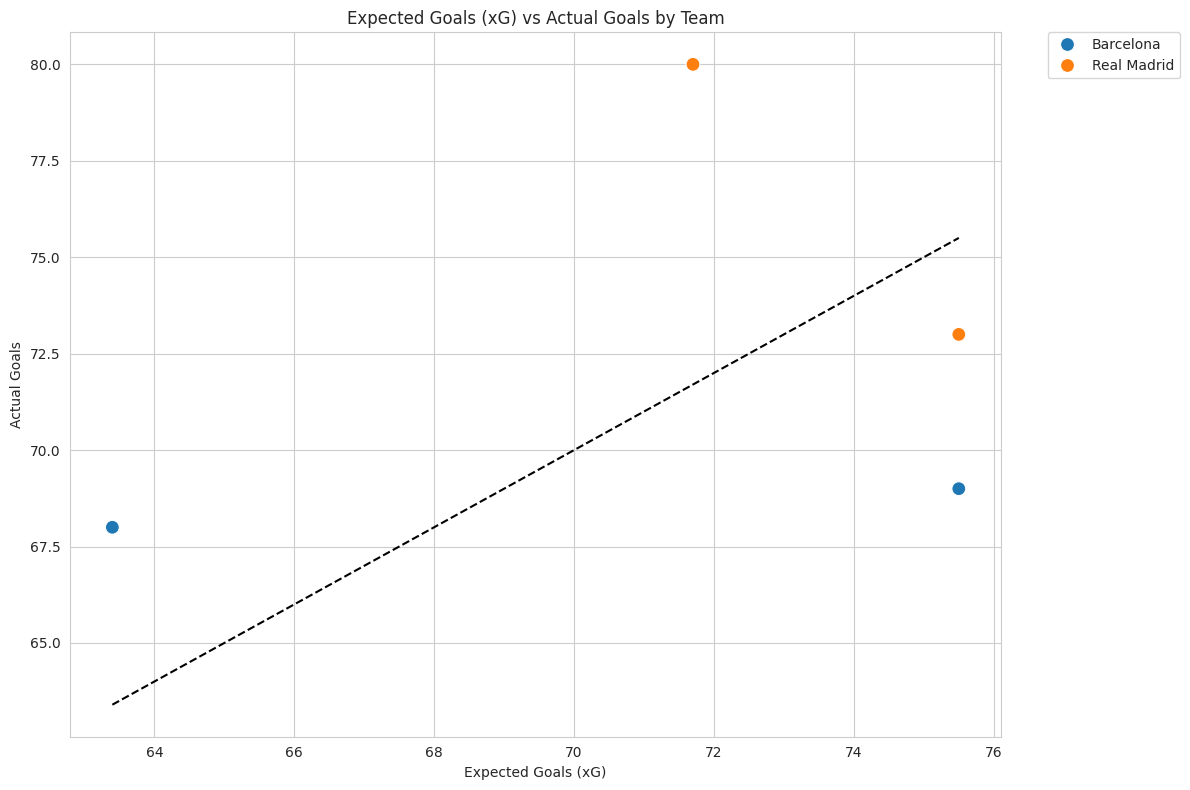

In [21]:
# Expected Goals vs Actual Goals by Team
def plot_team_xg_vs_goals(season_stats):
    if 'xG_Expected' not in season_stats.columns or 'Gls' not in season_stats.columns:
        print("Required columns not found in season_stats.")
        return

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=season_stats, x='xG_Expected', y='Gls', hue='Squad', s=100)
    plt.plot([season_stats['xG_Expected'].min(), season_stats['xG_Expected'].max()],
             [season_stats['xG_Expected'].min(), season_stats['xG_Expected'].max()], 'k--')
    plt.title('Expected Goals (xG) vs Actual Goals by Team')
    plt.xlabel('Expected Goals (xG)')
    plt.ylabel('Actual Goals')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

plot_team_xg_vs_goals(season_stats)

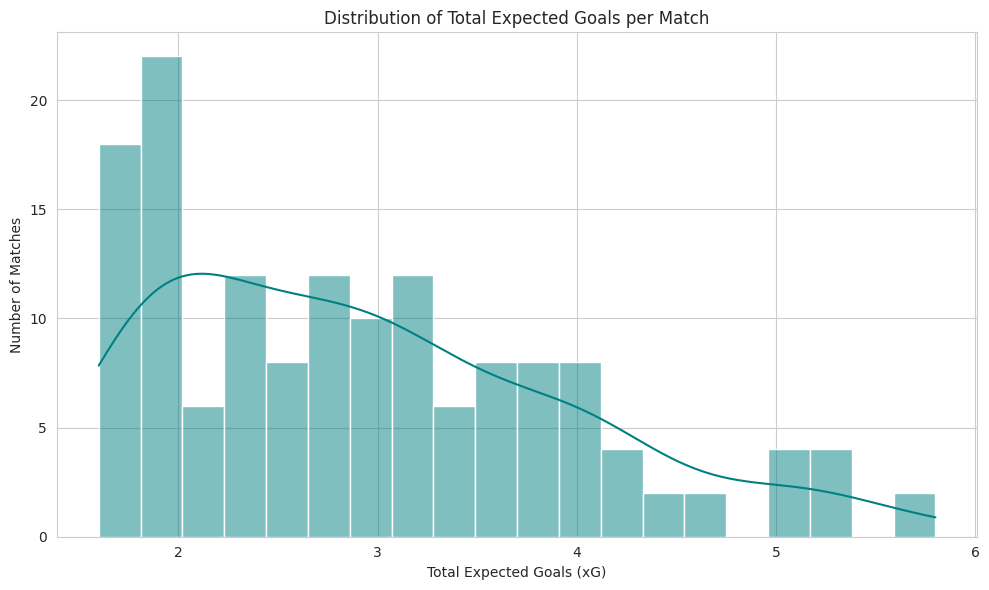

In [23]:
# Distribution of Expected Goals (xG) per Match
def plot_xg_distribution_per_match(match_results):
    if 'Home_xG' not in match_results.columns or 'Away_xG' not in match_results.columns:
        print("Required columns not found in match_results.")
        return

    match_results['Total_xG'] = match_results['Home_xG'] + match_results['Away_xG']

    plt.figure(figsize=(10, 6))
    sns.histplot(match_results['Total_xG'], bins=20, kde=True, color='teal')
    plt.title('Distribution of Total Expected Goals per Match')
    plt.xlabel('Total Expected Goals (xG)')
    plt.ylabel('Number of Matches')
    plt.tight_layout()
    plt.show()

plot_xg_distribution_per_match(match_results)

#⚠⚠ **NOTHING AFTER THIS POINT WORKS!!!!!** ⚠⚠  
I tried to understand why but I think it has something to do with the values in the dataset

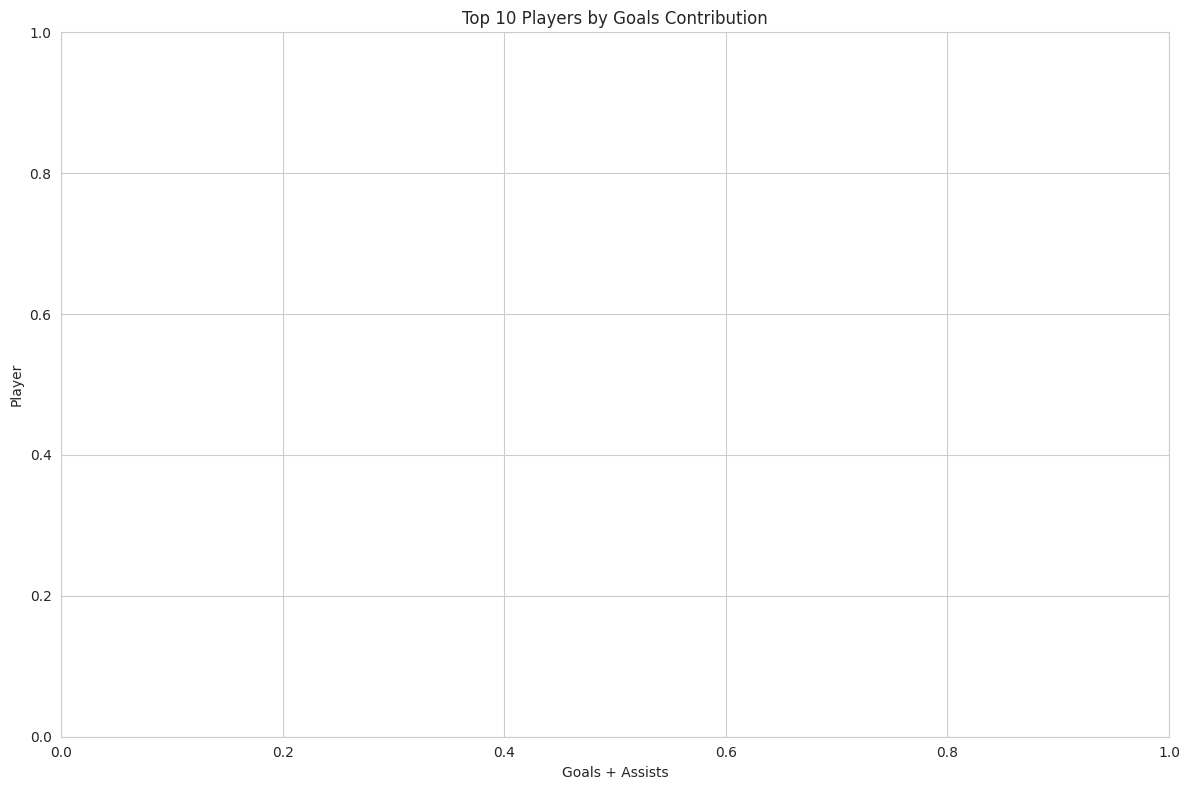

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [40]:
# Goals Contribution by Players (Goals + Assists)
def plot_goals_contribution(player_stats):
    if 'Gls' not in player_stats.columns or 'Ast' not in player_stats.columns:
        print("Required columns not found in player_stats.")
        return

    player_stats['Goals_Contribution'] = player_stats['Gls'] + player_stats['Ast']
    top_contributors = player_stats.groupby('Player')['Goals_Contribution'].sum().reset_index()
    top_contributors = top_contributors.sort_values('Goals_Contribution', ascending=False).head(10)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_contributors, x='Goals_Contribution', y='Player', color='magenta')
    plt.title('Top 10 Players by Goals Contribution')
    plt.xlabel('Goals + Assists')
    plt.ylabel('Player')
    plt.tight_layout()
    plt.
    plt.show()


plot_goals_contribution(player_stats)

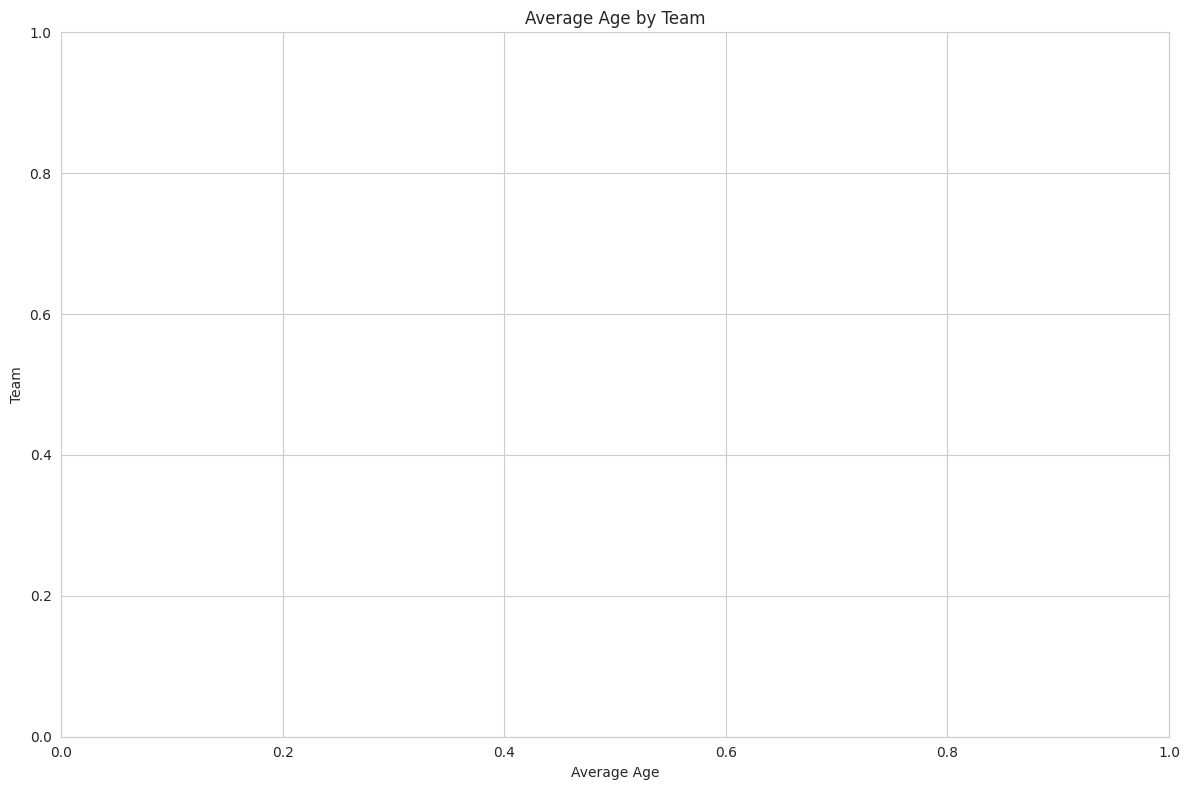

In [20]:
# Average Age of Teams
def plot_average_age_by_team(player_stats):
    if 'Age' not in player_stats.columns:
        print("Column 'Age' not found in player_stats.")
        return

    average_age = player_stats.groupby('Squad')['Age'].mean().reset_index()
    average_age = average_age.sort_values('Age', ascending=False)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(data=average_age, x='Age', y='Squad', color='violet')
    plt.title('Average Age by Team')
    plt.xlabel('Average Age')
    plt.ylabel('Team')
    plt.tight_layout()
    plt.show()

plot_average_age_by_team(player_stats)

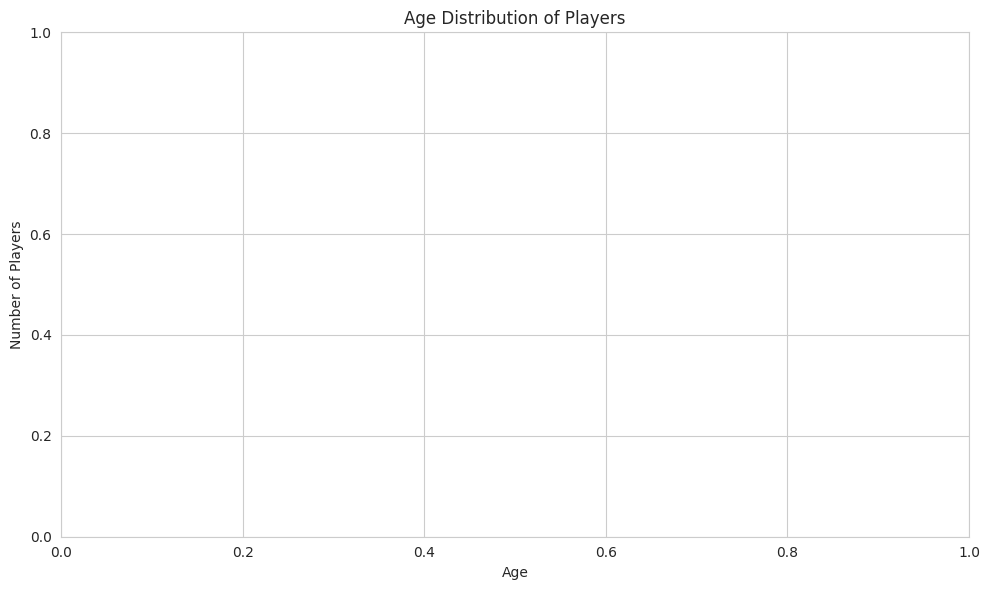

In [41]:
# UNOFORTUNATELY IT DOENS'T WORK

# Age Distribution of Players
def plot_age_distribution(player_stats):
    if 'Age' not in player_stats.columns:
        print("Column 'Age' not found in player_stats.")
        return

    plt.figure(figsize=(10, 6))
    sns.histplot(player_stats['Age'], bins=20, kde=True, color='skyblue')
    plt.title('Age Distribution of Players')
    plt.xlabel('Age')
    plt.ylabel('Number of Players')
    plt.tight_layout()

    plt.show()

plot_age_distribution(player_stats)

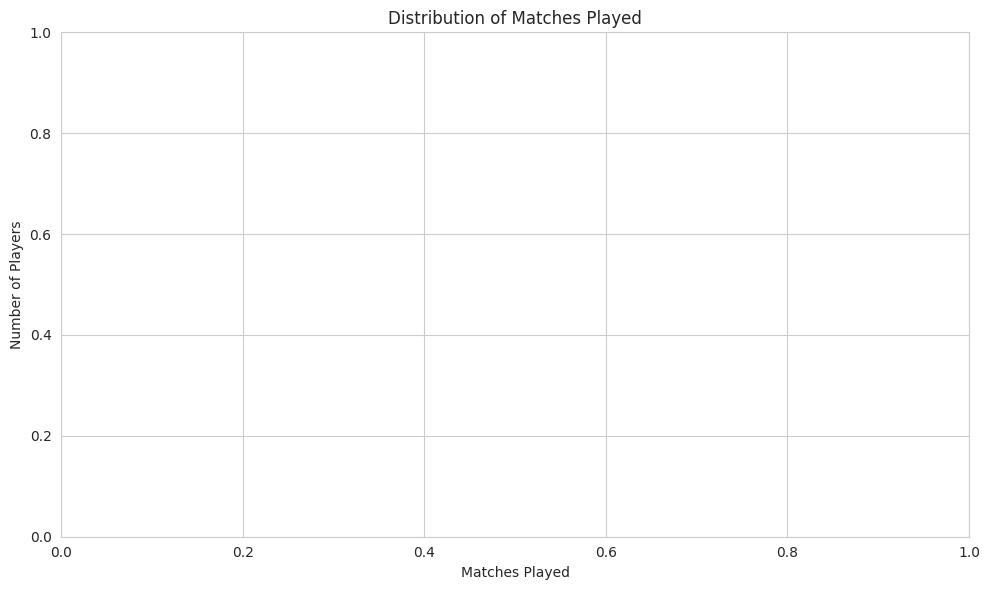

In [51]:
# Distribution of Matches Played
def plot_matches_played_distribution(player_stats):
    if 'MP' not in player_stats.columns:
        print("Column 'MP' not found in player_stats.")
        return

    plt.figure(figsize=(10, 6))
    sns.histplot(player_stats['MP'], bins=20, kde=False, color='orange')
    plt.title('Distribution of Matches Played')
    plt.xlabel('Matches Played')
    plt.ylabel('Number of Players')
    plt.tight_layout()
    plt.show()

plot_matches_played_distribution(player_stats)

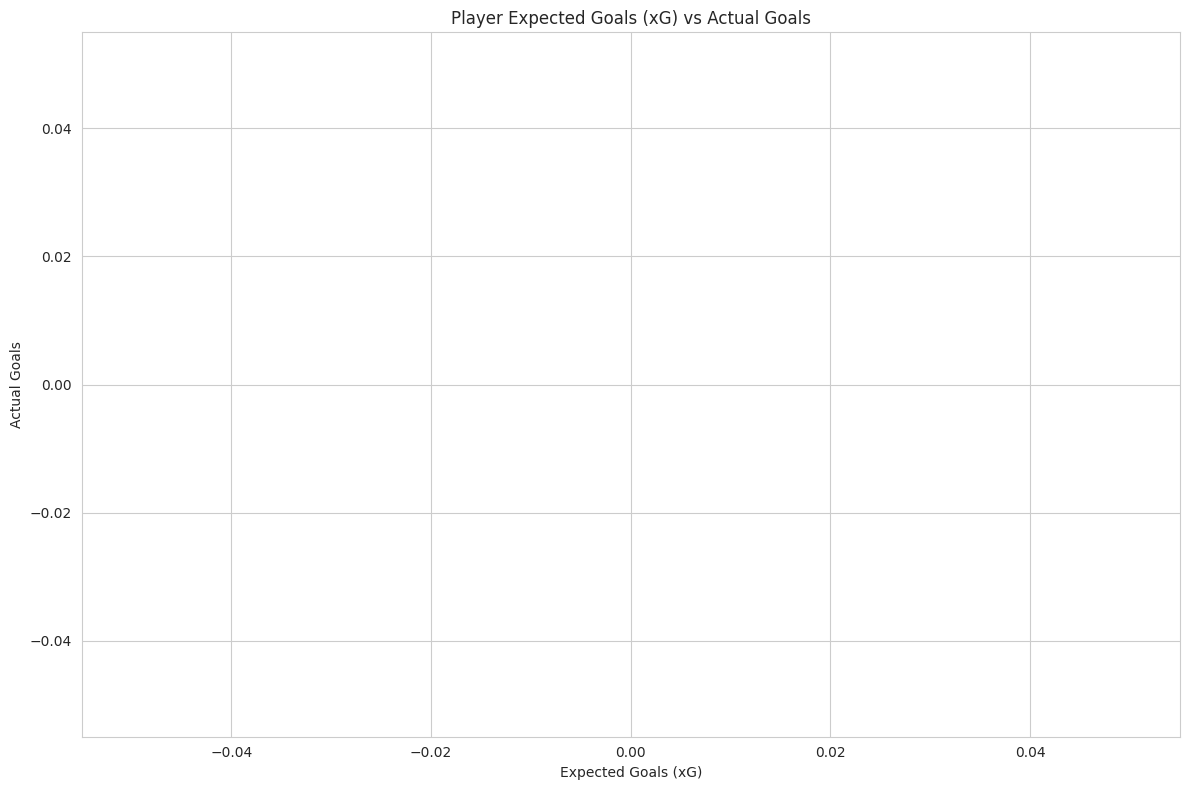

In [50]:
# Player xG vs Actual Goals
def plot_player_xg_vs_goals(player_stats):
    if 'Gls' not in player_stats.columns or 'xG_Expected' not in player_stats.columns:
        print("Required columns not found in player_stats.")
        return

    # Sum goals and xG per player
    player_xg_goals = player_stats.groupby('Player')[['Gls', 'xG_Expected']].sum().reset_index()
    player_xg_goals = player_xg_goals[player_xg_goals['Gls'] > 0]  # Filter players with at least one goal

    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=player_xg_goals, x='xG_Expected', y='Gls', hue='Player', legend=False)
    plt.plot([player_xg_goals['xG_Expected'].min(), player_xg_goals['xG_Expected'].max()],
             [player_xg_goals['xG_Expected'].min(), player_xg_goals['xG_Expected'].max()], 'k--')
    plt.title('Player Expected Goals (xG) vs Actual Goals')
    plt.xlabel('Expected Goals (xG)')
    plt.ylabel('Actual Goals')
    plt.tight_layout()
    plt.show()

plot_player_xg_vs_goals(player_stats)

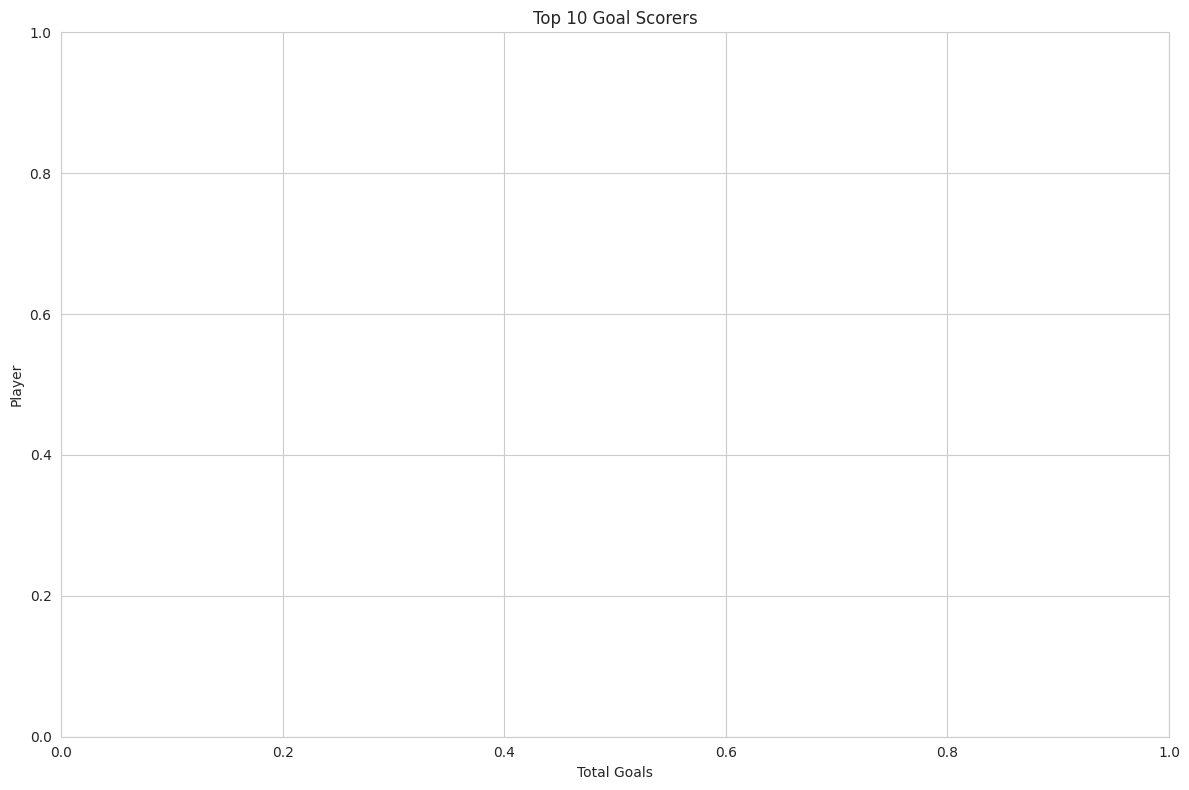

In [48]:
# Top 10 Goal Scorers
def plot_top_scorers(player_stats):
    if 'Gls' not in player_stats.columns:
        print("Column 'Gls' not found in player_stats.")
        return

    top_scorers = player_stats.groupby('Player')['Gls'].sum().reset_index()
    top_scorers = top_scorers.sort_values('Gls', ascending=False).head(10)

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_scorers, x='Gls', y='Player', color='purple')
    plt.title('Top 10 Goal Scorers')
    plt.xlabel('Total Goals')
    plt.ylabel('Player')
    plt.tight_layout()
    plt.show()

plot_top_scorers(player_stats)